## **1.1 $\texttt{SubEnv Synth}$ testing**

Experiments related to the $\texttt{SubEnv Synth}$.

In [1]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [2]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [3]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.seeds                 as seeds

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

In [17]:
# Computationnal functions ---------------------------------------------------------------------------------------

# Resysnthesis function
def resynthesize_segment(segment, sr, seed, N_filter_bank, param_per_env):
    #transform segment to tensor if it is numpy array
    if isinstance(segment, np.ndarray):
        segment = torch.tensor(segment, dtype=torch.float32)
    param_real, param_imag = sp.SubEnv_param_extractor(segment, sr, N_filter_bank, param_per_env)
    new_audio = sp.SubEnv(param_real, param_imag, seed)
    audio_resynth=new_audio.numpy()
    return audio_resynth

# Overlap and add function
def OLA(segments_resynthesis, frame_size, hop_size, window):
    N_segments = len(segments_resynthesis)
    audio_final = np.zeros(frame_size + (N_segments-1)*hop_size)
    for i in range(N_segments):
        synthesized_segment = segments_resynthesis[i]
        synthesized_segment = synthesized_segment * window
        audio_final[i * hop_size: i * hop_size + frame_size] += synthesized_segment
    audio_final = audio_final
    return audio_final

# Full resynthesis function
def resynthesis_full(audio, sr, seed, N_filter_bank, frame_size, param_per_env):
    hop_size = frame_size // 2
    # Make list of segments
    segments_og = []  
    for i in range(0, len(audio) - frame_size, hop_size):
        segments_og.append(audio[i:i + frame_size])
    # Resynthesize each segment using resynthesize function
    segments_resynthesis = []
    for i in range(len(segments_og)):
        segments_resynthesis.append(resynthesize_segment(segments_og[i], sr, seed, N_filter_bank, param_per_env))
    # Overlap and add the resynthesized segments using hann window and hop size
    audio_final = OLA(segments_resynthesis, frame_size, hop_size, np.hanning(frame_size))
    return audio_final

# Plotters ------------------------------------------------------------------------------------------------------

def plotter_resynth_experiment(audio_og, audio_resynth, sr, label):
    #play sound 1
    print(f"{label} original audio")
    display(Audio(data=audio_og, rate=sr))
    #play sound 2
    print(f"{label} resynthesized audio")
    display(Audio(data=audio_resynth, rate=sr))
    # Compute hop length as integer number nfft * overlap_ratio
    nfft = 2048
    hop_length = nfft // 4
    # Desired frequency ticks on the y-axis
    freq_ticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    time_ticks = [1, 2, 3, 4]
    # Make plots of spectrogram of original and resynthesized audio side by side using a Hann window
    plt.figure(figsize=(15, 5))
    # Original Audio Spectrogram
    plt.subplot(1, 2, 1)
    Pxx, freqs, bins, im = plt.specgram(audio_og, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 20 Hz and 10,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(time_ticks, labels=[str(t) for t in time_ticks])  # Set custom time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} original audio")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Resynthesized Audio Spectrogram
    plt.subplot(1, 2, 2)
    Pxx, freqs, bins, im = plt.specgram(audio_resynth, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 20 Hz and 10,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(time_ticks, labels=[str(t) for t in time_ticks])  # Set custom time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesized audio")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Final plot
    plt.tight_layout()
    plt.show()
    
def plotter_seed_experiment(audio_1, audio_2, audio_3, sr, label):
    # Play sound 1
    print(f"{label} resynthesis with seed 1")
    display(Audio(data=audio_1, rate=sr))
    # Play sound 2
    print(f"{label} resynthesis with seed 2")
    display(Audio(data=audio_2, rate=sr))
    # Play sound 3
    print(f"{label} resynthesis with seed 1")
    display(Audio(data=audio_3, rate=sr))
    # Compute hop length as integer number nfft * overlap_ratio
    nfft = 2048
    hop_length = nfft // 4
    # Desired frequency ticks on the y-axis
    freq_ticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    # Time ticks (adjust these as necessary for your data)
    time_ticks = [0, 1, 2, 3, 4]  # Example time ticks, adjust if needed
    # Create a figure with subplots for each audio sample
    plt.figure(figsize=(22.5, 5))
    # Spectrogram for the first audio sample
    plt.subplot(1, 3, 1)
    Pxx, freqs, bins, im = plt.specgram(audio_1, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_1)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 1")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Spectrogram for the second audio sample
    plt.subplot(1, 3, 2)
    Pxx, freqs, bins, im = plt.specgram(audio_2, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_2)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 2")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Spectrogram for the third audio sample
    plt.subplot(1, 3, 3)
    Pxx, freqs, bins, im = plt.specgram(audio_3, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
    plt.ylim(31.25, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
    plt.yscale('log')  # Plot on a logarithmic scale
    plt.yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
    plt.xticks(np.linspace(0, len(audio_3)/sr, num=len(time_ticks)), labels=[str(t) for t in time_ticks])  # Adjust time ticks
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.title(f"{label} resynthesis with seed 3")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    # Show the plot
    plt.tight_layout()
    plt.show()

# Actual experiments --------------------------------------------------------------------------------------------

from ddsp_textures.loss.functions import multiscale_spectrogram_loss, statistics_loss
import ddsp_textures.auxiliar.filterbanks as fb

def resynthesis_segment_accuracy(segments_list, sr, seed, N_filter_bank, param_per_env, frame_size, label):
    #for loss calculation
    erb_bank = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    new_size = frame_size // 4
    new_sample_rate = sr // 4
    log_bank = fb.Logarithmic(new_size, new_sample_rate, 6, 20, new_sample_rate // 2)
    multiscale_loss_list = []
    statistics_loss_list = []
    j=0
    for segment in segments_list:
        j=j+1
        x = segment
        x_hat = resynthesize_segment(segment, sr, seed, N_filter_bank, param_per_env)
        x_hat = torch.tensor(x_hat, dtype=torch.float32)
        multiscale_loss_list.append(multiscale_spectrogram_loss(x, x_hat))
        statistics_loss_list.append(statistics_loss(x, x_hat, N_filter_bank, sr, erb_bank, log_bank))
        print(f"Segment {j} done")
    #Compute the average and std of each loss. They are lists of tensors:
    multiscale_loss_list = torch.stack(multiscale_loss_list)
    statistics_loss_list = torch.stack(statistics_loss_list)
    multiscale_loss_avg = torch.mean(multiscale_loss_list)
    statistics_loss_avg = torch.mean(statistics_loss_list)
    multiscale_loss_std = torch.std(multiscale_loss_list)
    statistics_loss_std = torch.std(statistics_loss_list)
    print(f"{label} multiscale loss average: {multiscale_loss_avg}")
    print(f"{label} statistics loss average: {statistics_loss_avg}")
    print(f"{label} multiscale loss std: {multiscale_loss_std}")
    print(f"{label} statistics loss std: {statistics_loss_std}")
    return multiscale_loss_avg, statistics_loss_avg, multiscale_loss_std, statistics_loss_std

def segmentation(audio_numpy, frame_size):
    audio_numpy_size = len(audio_numpy)
    segments_number = audio_numpy_size // frame_size
    segments_list = []
    for i in range(0,segments_number):
        segment_local = audio_numpy[i*frame_size:(i+1)*frame_size]
        segment_local_tensor = torch.tensor(segment_local, dtype=torch.float32)
        segments_list.append(segment_local_tensor)
    return segments_list

def loss_reporter(audio_1_np, audio_2_np, frame_size, sr, N_filter_bank):
    #for loss calculation
    erb_bank = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    new_size = frame_size // 4
    new_sample_rate = sr // 4
    log_bank = fb.Logarithmic(new_size, new_sample_rate, 6, 20, new_sample_rate // 2)
    segments_1 = segmentation(audio_1_np, frame_size)
    segments_2 = segmentation(audio_2_np, frame_size)
    multiscale_loss_list = []
    statistics_loss_list = []
    j=0
    for i in range(len(segments_1)):
        j=j+1
        x = segments_1[i]
        x_hat = segments_2[i]
        multiscale_loss_list.append(multiscale_spectrogram_loss(x, x_hat))
        statistics_loss_list.append(statistics_loss(x, x_hat, N_filter_bank, sr, erb_bank, log_bank))
        print(f"Segment {j} done")
    #Compute the average and std of each loss. They are lists of tensors:
    multiscale_loss_list = torch.stack(multiscale_loss_list)
    statistics_loss_list = torch.stack(statistics_loss_list)
    multiscale_loss_avg = torch.mean(multiscale_loss_list)
    statistics_loss_avg = torch.mean(statistics_loss_list)
    multiscale_loss_std = torch.std(multiscale_loss_list)
    statistics_loss_std = torch.std(statistics_loss_list)
    print(f"Multiscale loss average: {multiscale_loss_avg}")
    print(f"Statistics loss average: {statistics_loss_avg}")
    print(f"Multiscale loss std: {multiscale_loss_std}")
    print(f"Statistics loss std: {statistics_loss_std}")
    return multiscale_loss_avg, statistics_loss_avg, multiscale_loss_std, statistics_loss_std
    

def resynthesis_experiment(audio, sr, label, seed, N_filter_bank, frame_size, param_per_env):
    audio_resynth = resynthesis_full(audio, sr, seed, N_filter_bank, frame_size, param_per_env)
    plotter_resynth_experiment(audio, audio_resynth, sr, label)

def seed_experiment(audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env):
    seed_1=seeds_list[0]
    seed_2=seeds_list[1]
    seed_3=seeds_list[2]
    audio_resynth_1 = resynthesis_full(audio, sr, seed_1, N_filter_bank, frame_size, param_per_env)
    audio_resynth_2 = resynthesis_full(audio, sr, seed_2, N_filter_bank, frame_size, param_per_env)
    audio_resynth_3 = resynthesis_full(audio, sr, seed_3, N_filter_bank, frame_size, param_per_env)
    plotter_seed_experiment(audio_resynth_1, audio_resynth_2, audio_resynth_3, sr, label)
    return audio_resynth_1, audio_resynth_2, audio_resynth_3


### **Measuring the accuracy of the resynthesis task** 

In [8]:
# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire_augmented.wav"
label = "Fire"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = librosa.util.normalize(fire_audio)
fire_audio = librosa.effects.preemphasis(fire_audio)
N_filter_bank = 24 # This is a high number of filter (16 is the typical)
frame_size = 2**15 # around 1.48 seconds
param_per_env = 512  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)
segments_number=100
segments_list = []

for i in range(0,segments_number):
    segment_local = fire_audio[i*frame_size:(i+1)*frame_size]
    segment_local_tensor = torch.tensor(segment_local, dtype=torch.float32)
    segments_list.append(segment_local_tensor)
    
resynthesis_segment_accuracy(segments_list, sr, seed, N_filter_bank, param_per_env, frame_size, label)

parameter_number = N_filter_bank * param_per_env
compression = frame_size / parameter_number
print(f"Compression ratio: {compression}")


Segment 1 done
Segment 2 done
Segment 3 done
Segment 4 done
Segment 5 done
Segment 6 done
Segment 7 done
Segment 8 done
Segment 9 done
Segment 10 done
Segment 11 done
Segment 12 done
Segment 13 done
Segment 14 done
Segment 15 done
Segment 16 done
Segment 17 done
Segment 18 done
Segment 19 done
Segment 20 done
Segment 21 done
Segment 22 done
Segment 23 done
Segment 24 done
Segment 25 done
Segment 26 done
Segment 27 done
Segment 28 done
Segment 29 done
Segment 30 done
Segment 31 done
Segment 32 done
Segment 33 done
Segment 34 done
Segment 35 done
Segment 36 done
Segment 37 done
Segment 38 done
Segment 39 done
Segment 40 done
Segment 41 done
Segment 42 done
Segment 43 done
Segment 44 done
Segment 45 done
Segment 46 done
Segment 47 done
Segment 48 done
Segment 49 done
Segment 50 done
Segment 51 done
Segment 52 done
Segment 53 done
Segment 54 done
Segment 55 done
Segment 56 done
Segment 57 done
Segment 58 done
Segment 59 done
Segment 60 done
Segment 61 done
Segment 62 done
Segment 63 done
S

In [14]:
# Load audio to resynthesize ----------------------------
water_path = "../data/sounds/water.wav"
label = "Water"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)
water_audio = librosa.util.normalize(water_audio)
N_filter_bank = 16 # This is a high number of filter (16 is the typical)
frame_size = 2**15 # around 1.48 seconds
param_per_env = 256  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)
segments_number=100
segments_list = []

for i in range(0,segments_number):
    segment_local = fire_audio[i*frame_size:(i+1)*frame_size]
    segment_local_tensor = torch.tensor(segment_local, dtype=torch.float32)
    segments_list.append(segment_local_tensor)
    
resynthesis_segment_accuracy(segments_list, sr, seed, N_filter_bank, param_per_env, frame_size, label)

parameter_number = N_filter_bank * param_per_env
compression = frame_size / parameter_number
print(f"Compression ratio: {compression}")

Segment 1 done
Segment 2 done
Segment 3 done
Segment 4 done
Segment 5 done
Segment 6 done
Segment 7 done
Segment 8 done
Segment 9 done
Segment 10 done
Segment 11 done
Segment 12 done
Segment 13 done
Segment 14 done
Segment 15 done
Segment 16 done
Segment 17 done
Segment 18 done
Segment 19 done
Segment 20 done
Segment 21 done
Segment 22 done
Segment 23 done
Segment 24 done
Segment 25 done
Segment 26 done
Segment 27 done
Segment 28 done
Segment 29 done
Segment 30 done
Segment 31 done
Segment 32 done
Segment 33 done
Segment 34 done
Segment 35 done
Segment 36 done
Segment 37 done
Segment 38 done
Segment 39 done
Segment 40 done
Segment 41 done
Segment 42 done
Segment 43 done
Segment 44 done
Segment 45 done
Segment 46 done
Segment 47 done
Segment 48 done
Segment 49 done
Segment 50 done
Segment 51 done
Segment 52 done
Segment 53 done
Segment 54 done
Segment 55 done
Segment 56 done
Segment 57 done
Segment 58 done
Segment 59 done
Segment 60 done
Segment 61 done
Segment 62 done
Segment 63 done
S

Fire original audio


Fire resynthesized audio


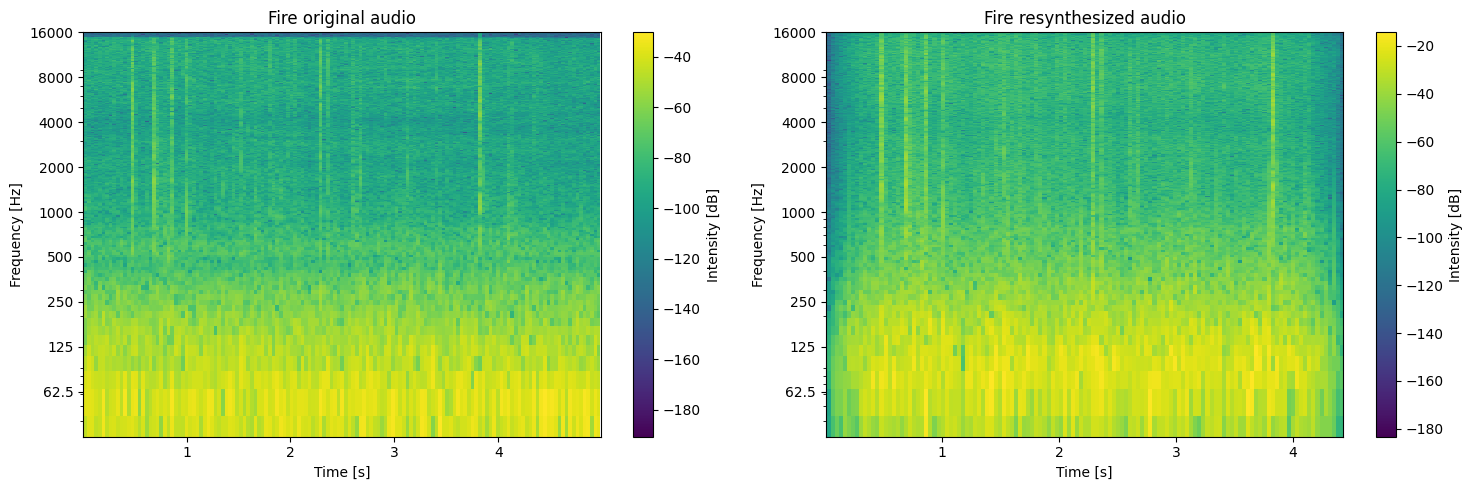

In [15]:
# FIRE RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire_augmented.wav"
label = "Fire"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = fire_audio[ 60*sr: 65*sr] # Limit to 5 seconds

# Seed creation -----------------------------------------
N_filter_bank = 24 # This is a high number of filter (16 is the typical)
frame_size = 2**16 # around 1.48 seconds
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer
param_per_env = 1024  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
resynthesis_experiment(fire_audio, sr, label, seed, N_filter_bank, frame_size, param_per_env)

### Experiment 2: Resynthesis Task - Water sounds

Water original audio


Water resynthesized audio


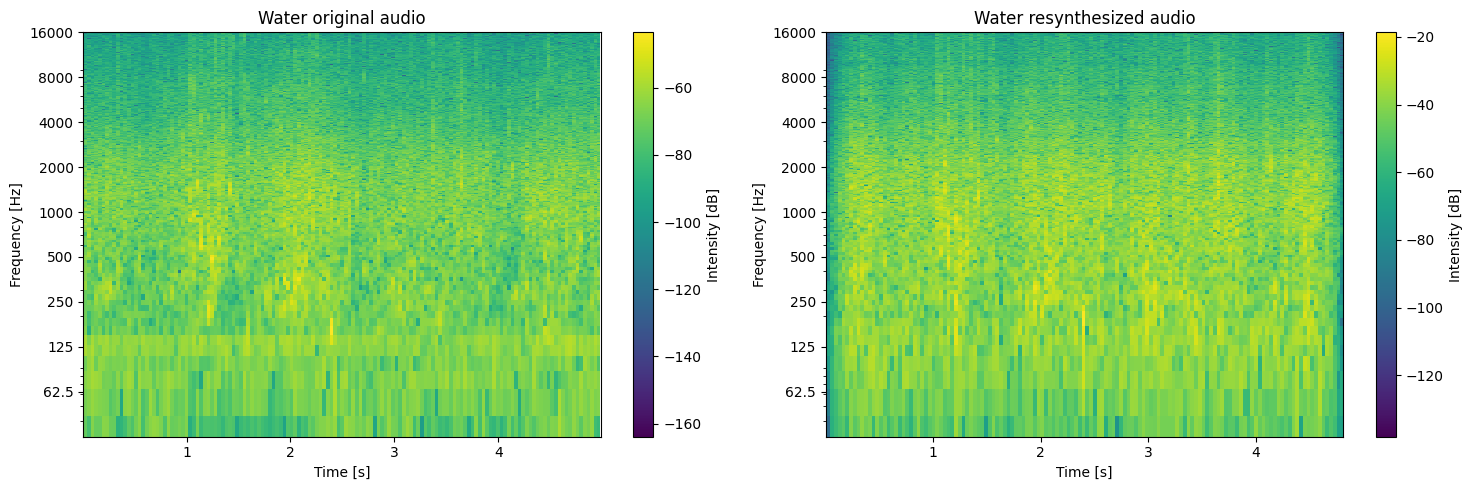

In [16]:
# WATER RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
water_path = "../data/sounds/water.wav"
label = "Water"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)
water_audio = water_audio[ : 5*sr] # Limit to 5 seconds

# Seed creation -----------------------------------------
N_filter_bank = 16
frame_size = 2**15 # around 0.38 seconds
seed = seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 256  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4
resynthesis_experiment(water_audio, sr, label, seed, N_filter_bank, frame_size, param_per_env)

### Experiment 3: Seed exploration - fire sounds

Fire resynthesis with seed 1


Fire resynthesis with seed 2


Fire resynthesis with seed 1


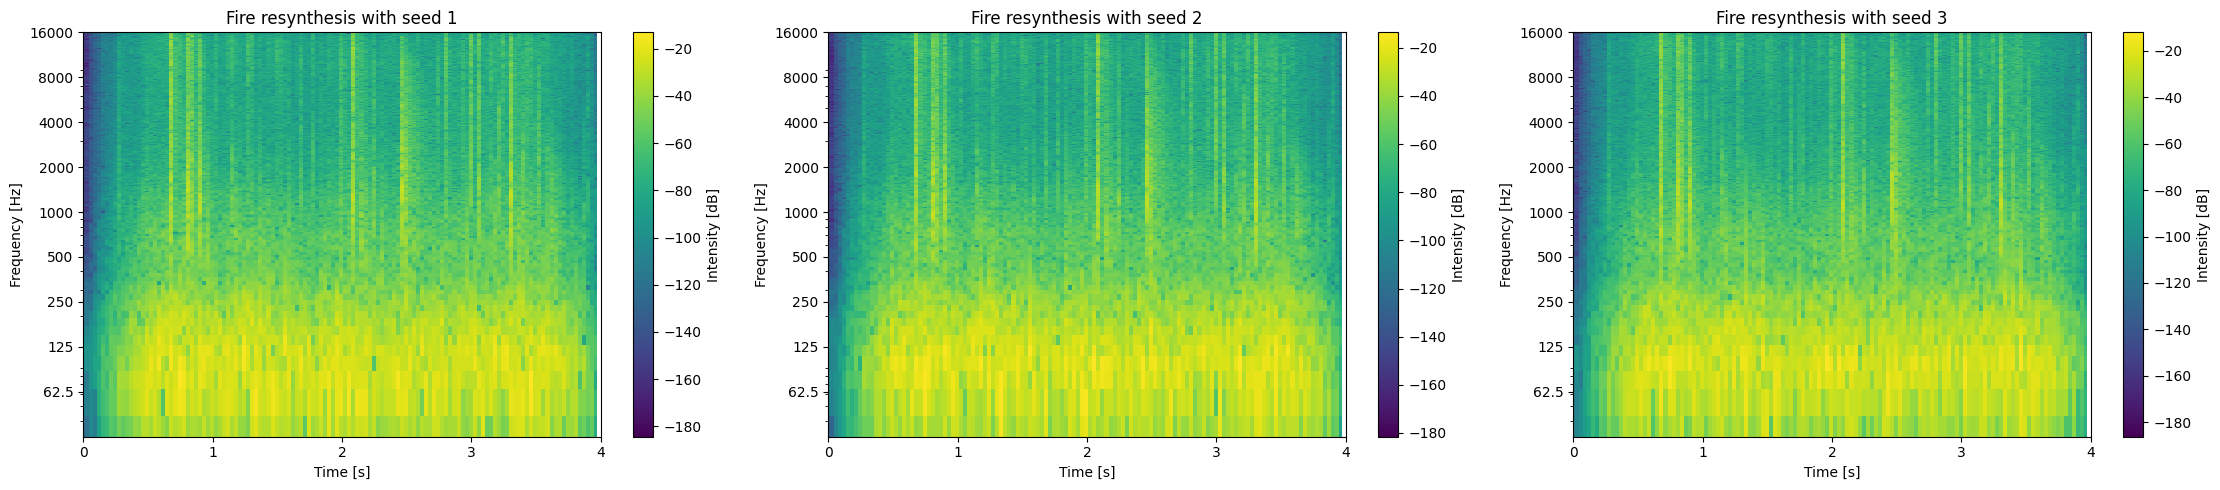

Segment 1 done
Segment 2 done
Segment 3 done
Multiscale loss average: 4.410874843597412
Statistics loss average: 0.5600874423980713
Multiscale loss std: 0.049678925424814224
Statistics loss std: 0.027561482042074203
Segment 1 done
Segment 2 done
Segment 3 done
Multiscale loss average: 4.424925327301025
Statistics loss average: 0.5631479620933533
Multiscale loss std: 0.0565471313893795
Statistics loss std: 0.029280586168169975
Segment 1 done
Segment 2 done
Segment 3 done
Multiscale loss average: 4.415874004364014
Statistics loss average: 0.5556182265281677
Multiscale loss std: 0.04997210577130318
Statistics loss std: 0.023672861978411674


(tensor(4.4159), tensor(0.5556), tensor(0.0500), tensor(0.0237))

In [19]:
# Fire resynthesis with multiple seeds:

# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire.wav"
label = "Fire"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = fire_audio[ : 5*sr] # Limit to 5 seconds

# Seed parameters ----------------------------------------
N_filter_bank = 24 # This is a high number of filter (16 is the typical)
frame_size = 2**16 # around 1.48 seconds
seeds_list = []
for i in range(3):
    seeds_list.append(seeds.seed_maker(frame_size, 44100, N_filter_bank))

# Run the resynthesizer
param_per_env = 1024  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
audio_1, audio_2, audio_3 = seed_experiment(fire_audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env)

loss_reporter(audio_1, audio_2, frame_size, sr, N_filter_bank)
loss_reporter(audio_1, audio_3, frame_size, sr, N_filter_bank)
loss_reporter(audio_2, audio_3, frame_size, sr, N_filter_bank)


### Experiment 4: seed exploration - water sounds

Water resynthesis with seed 1


Water resynthesis with seed 2


Water resynthesis with seed 1


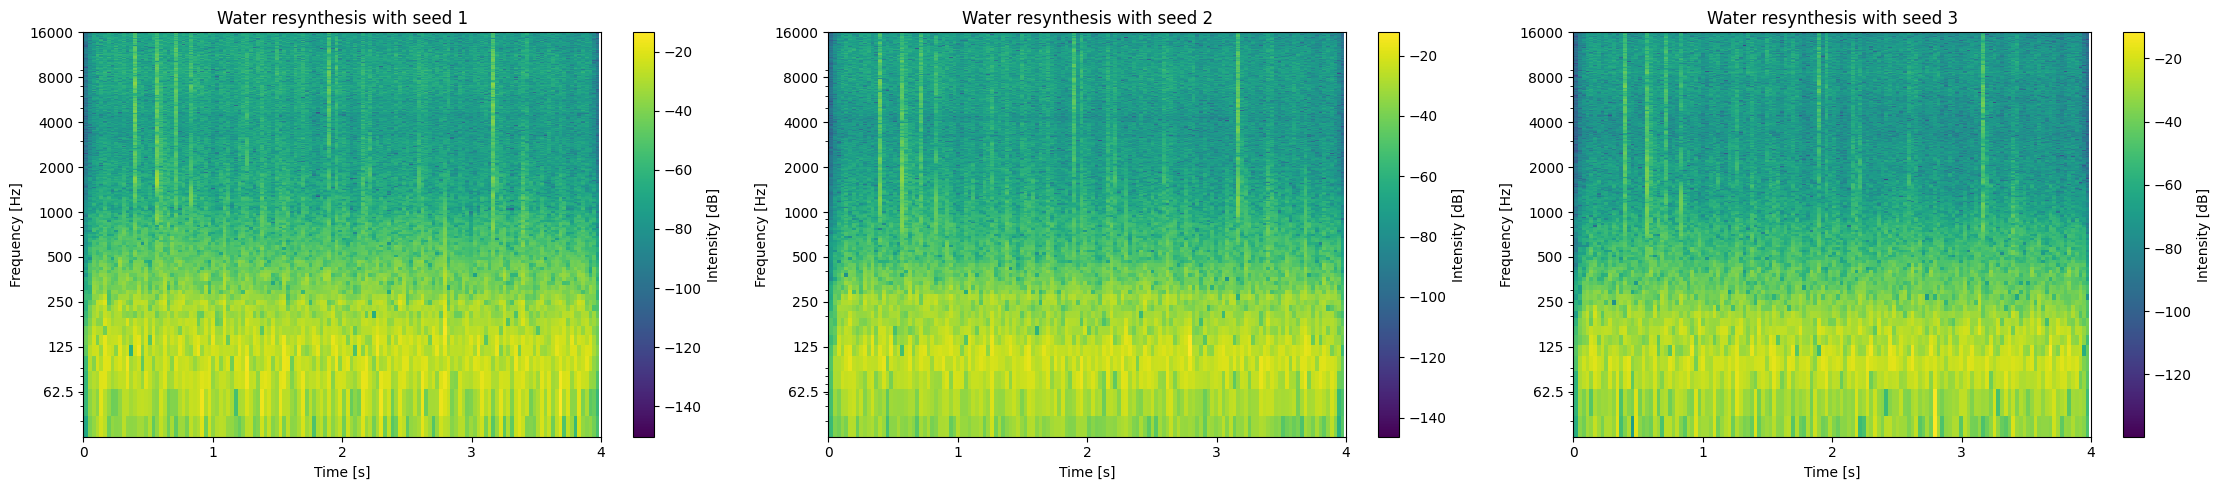

Segment 1 done
Segment 2 done
Segment 3 done
Segment 4 done
Segment 5 done
Segment 6 done
Segment 7 done
Segment 8 done
Segment 9 done
Segment 10 done
Segment 11 done
Segment 12 done
Segment 13 done
Multiscale loss average: 4.567093372344971
Statistics loss average: 0.5980275869369507
Multiscale loss std: 0.06370077282190323
Statistics loss std: 0.022691210731863976
Segment 1 done
Segment 2 done
Segment 3 done
Segment 4 done
Segment 5 done
Segment 6 done
Segment 7 done
Segment 8 done
Segment 9 done
Segment 10 done
Segment 11 done
Segment 12 done
Segment 13 done
Multiscale loss average: 4.600786209106445
Statistics loss average: 0.6264630556106567
Multiscale loss std: 0.05758573114871979
Statistics loss std: 0.0313834622502327
Segment 1 done
Segment 2 done
Segment 3 done
Segment 4 done
Segment 5 done
Segment 6 done
Segment 7 done
Segment 8 done
Segment 9 done
Segment 10 done
Segment 11 done
Segment 12 done
Segment 13 done
Multiscale loss average: 4.556398391723633
Statistics loss averag

(tensor(4.5564), tensor(0.6030), tensor(0.0475), tensor(0.0199))

In [18]:
# Water resynthesis with multiple seeds:

# Load audio to resynthesize ----------------------------
water_path = "../data/sounds/water.wav"
label = "Water"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)
fire_audio = fire_audio[ : 5*sr] # Limit to 5 seconds

# Seed parameters ----------------------------------------
N_filter_bank = 16
frame_size = 2**14 # around 0.38 seconds
seeds_list = []
for i in range(3):
    seeds_list.append(seeds.seed_maker(frame_size, 44100, N_filter_bank))
    
# Run the resynthesizer
param_per_env = 256  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
audio_1, audio_2, audio_3 = seed_experiment(fire_audio, sr, label, seeds_list, N_filter_bank, frame_size, param_per_env)

loss_reporter(audio_1, audio_2, frame_size, sr, N_filter_bank)
loss_reporter(audio_1, audio_3, frame_size, sr, N_filter_bank)
loss_reporter(audio_2, audio_3, frame_size, sr, N_filter_bank)
